# MFCC theory and implementation
## Theory
Mel Frequency Cepstral Coefficents (MFCCs) is a way of extracting features from an audio. The MFCC uses the MEL scale to divide the frequency band to sub-bands and then extracts the Cepstral Coefficents using Discrete Cosine Transform (DCT). MEL scale is based on the way humans distinguish between frequencies which makes it very convenient to process sounds.

Lets first understand how humans perceive sounds.

Dataset for this simulation can be obtained in: https://www.kaggle.com/c/freesound-audio-tagging/data

## Human voice sound perception
Adult humans fundamental voice frequency range is between 85Hz to 255Hz (85Hz to 180Hz for male and 165Hz to 255Hz for female). On top of the fundamental frequency there are harmonics of fundamental frequencys. Harmonics are whole multiplications of the fundamental frequency. If for instance the fundamental frequency is 100Hz then its second harmonic will be 200Hz, third harmonic is 300Hz and so on.

You can see an example in the image below [1] which shows frequency vs. time of several pronounced words and color represents frequency power at that point (yellow strongest and black weakest):

<img src="https://static.scientificamerican.com/sciam/assets/media/sound/speechsep-audio/speechsep-2-spect.png">


Notice the first horizontal yellow line on the bottom of each segment. That is the fundamental frequency and its the strongest. Above that there are harmonics with the same frequncy distance from each other.

Humans can hear roughly between 20Hz to 20KHz. The perception of sound is non-linear [2] and you can better distinguish between low frequency sounds than high frequency sounds e.g. humans can clearly hear the difference betwee 100Hz and 200Hz but not between 15kHz and 15.1kHz.

You can try in usin a tone generator: http://www.szynalski.com/tone-generator/

## MEL scale
A MEL scale is a unit of PITCH proposed by Stevens, Volkmann and Newmann in 1937. The MEL scale is a scale of pitches judged by listeners to be equal in distance one from another [3] [4]. Because of how humans perceive sound the MEL scale is a non-lenear scale and the distances between the pitches increeses with frequency.

# MFCC implementation [5] [6]
## Sample signal
First, lets load a sample audio and start working with it:

In [34]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [154]:
# filename = "a439d172_16khz.wav"
# filename = "a2002011001-e02-16kHz.wav"
# filename = "../f2bjrop1.0.wav"
filename = "../software/dataset/house//7192fddc_nohash_0.wav"
ipd.Audio(filename)

In [155]:
# sample_rate, audio = wavfile.read(TRAIN_PATH + "a439d172_16khz.wav")
sample_rate, audio = wavfile.read(filename)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))
print(audio)

Sample rate: 16000Hz
Audio duration: 1.0s
[  48   88   75 ... -160  -67  -45]


Bonus: notice that the sample rate is 44.1kHz which is the standart sampling rate for audio files. This number is not a coincidence. Acording to Nyquist, that sampling rate of 44.1kHz give us band-width of 22.05kHz. The 0Hz to 22.05kHz zone is called the first Nyquist zone, 22.05kHz to 44.1kHz is the second Nyquist zone and so on. If there is a signal in the second Nyquist zone (lets say 22.1kHz) it will alias to the first Nyquist zone (22kHz in our case). We dont want this to happend so we add a low pass filter (LPF). All LPFs has a pass-band, stop-band and transition band. 

<img src="http://msp.ucsd.edu/techniques/v0.11/book-html/img855.png", width=300, height=1>

The sampling frequency of 44.1kHz was chose so that the transition band will be from 20kHz (pass-band) to 22.05kHz (stop-band). It is important to have at least half of the transition band inside the first Nyquist zone because there is stil not enought attenuetion in the filter in this part so there might be aliases from the second Nyquist zone.

In [156]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

[  48   88   75 ... -160  -67  -45]


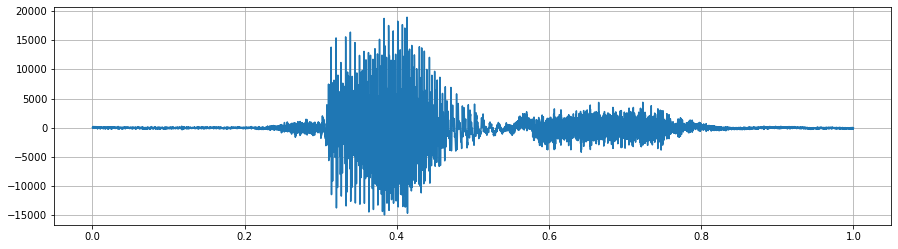

In [157]:
# audio = normalize_audio(audio) 
# audio = audio[:, 0] # keep only one channel
# audio = audio[:2000]
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)
print(audio)

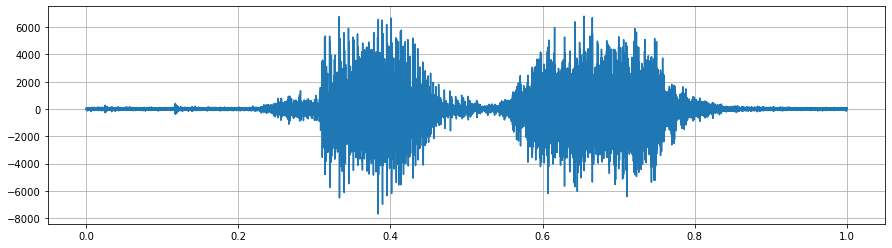

In [158]:
# PRE EMPHASIS

emphasis_coeff = 0.96875
audio_emphasis = np.append(audio[0], audio[1:] - emphasis_coeff * audio[:-1])
plt.figure(figsize=(15,4))
# plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.plot(np.linspace(0, len(audio_emphasis) / sample_rate, num=len(audio_emphasis)), audio_emphasis)
plt.grid(True)

There is a lot going on here. It sounds that we should get high and low fundamental frequencies.

## Audio Framing
Because audio is a non stationary process, the FFT will produce distortions. To overcome this we can assume that the audio is a stationary process for a short periods of time. Because of that we devide the signal into short frames. Each audio frame will be the same size as the FFT. Also we want the frames to overlap. We do that so that the frames will have some correlation between them and because we loose the information on the edges of each frame after applying a window function.

In [159]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    print("before", len(audio))
    # audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    # print("after", len(audio))
    # hop_len = np.round(sample_rate * hop_size / 1000).astype(int)
    hop_len = 170 # XXX
    frame_num = int((len(audio) - FFT_size) / hop_len) + 1 # XXX last one with padding ??
    print("number of frames", frame_num)
    frames = np.zeros((frame_num,FFT_size))
    overlap = int((hop_len / FFT_size) * 100) # percent
    frame_duration = int(FFT_size / sample_rate * 1000) # ms
    
    for n in range(frame_num):
        frames[n] = audio[n*hop_len:n*hop_len+FFT_size]
    
    return frames, hop_len, frame_duration, overlap

In [160]:
# sample_rate = # 16000
hop_size = 10 # 15 # 15 #ms
FFT_size = 512 # 2048

audio_framed, hop_len, frame_duration, overlap = frame_audio(audio_emphasis, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))
print("frame_duration: {}ms, hop_len: {}, overlap {}%".format(frame_duration, hop_len, overlap))

before 16000
number of frames 92
Framed audio shape: (92, 512)
frame_duration: 32ms, hop_len: 170, overlap 33%


In [161]:
audio.shape
# print(audio_framed[12])

(16000,)

In [162]:
# FFT_size=2048
# hop_size=10
# sample_rate=44100

# np.pad(audio, int(FFT_size / 2), mode='reflect').shape

Now we have framed audio matrix with the size of frame number X FFT size.

First frame: (len: 512)


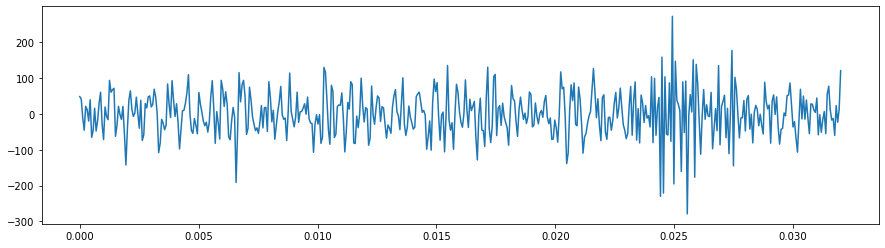

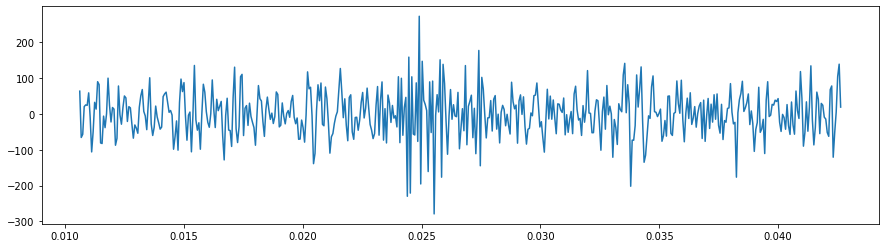

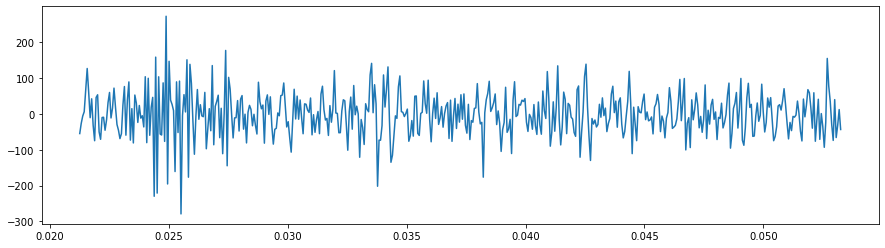

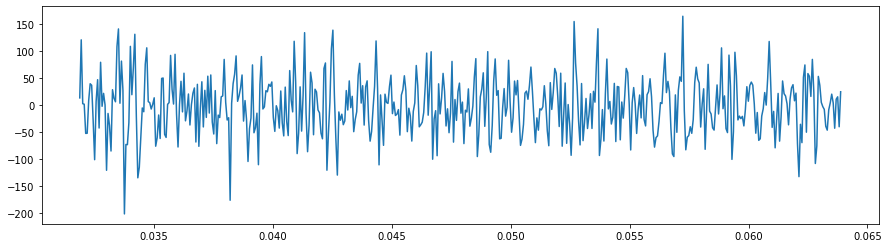

In [163]:
print("First frame: (len: {})".format(len(audio_framed[1])))
findex = 0
# print(audio_framed[findex])
for i, frame in enumerate(audio_framed):
    if i >= findex and i < (findex + 4):
        plt.figure(figsize=(15,4))
        plt.plot(np.linspace(i*hop_len/sample_rate, (i*hop_len+FFT_size) / sample_rate, num=len(frame)), frame)

In [164]:
print("Last frame:")
# audio_framed[-1]

Last frame:


## Convert to frequency domain
Now we will convert the audio, which is currently in the time domain, to frequency domain. The FFT assumes the audio to be periodic and continues. By framing the signal we assured the audio to be periodic. To make the audio continues, we apply a window function on every frame. If we wont do that, We will get high frequency distortions. To overcome this, we first need to apply a window function to the framed audio and then perforn FFT. The window assures that both ends of the signal will end close to zero.

Choosing the correct window is hard and takes time. For simplicity we will choose the Hanning window. [7]

after: 275
a, b 276 279
raw offset 2
1/2 [40, 40, 41, 41, 42, 42, 43, 44, 45, 46, 47, 49, 51, 52, 54, 56, 58, 61, 63, 65, 68, 71, 74, 77, 80, 83, 87, 90, 94, 97, 101, 105, 109, 113, 118, 122, 126, 131, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 191, 196, 202, 207, 213, 218, 224, 230, 235, 241, 247, 252, 258, 264, 270]
576
small [0, 1, 1, 1, 2, 3, 3, 4, 5, 7, 8, 10, 11, 13, 15, 17, 19, 22, 24, 27, 30, 32, 35, 38, 42, 45, 48, 52, 56, 59, 63, 67, 71, 75, 80, 84, 89, 93, 98, 102, 107, 112, 117, 122, 127, 132, 138, 143, 148, 154, 159, 164, 170, 176, 181, 187, 192, 198, 204, 210, 215, 221, 227, 233]
small0 0
[0, 1, 1, 1, 2, 3, 3, 4, 5, 7, 8, 10, 11, 13, 15, 17, 19, 22, 24, 27, 30, 32, 35, 38, 42, 45, 48, 52, 56, 59, 63, 67, 71, 75, 80, 84, 89, 93, 98, 102, 107, 112, 117, 122, 127, 132, 138, 143, 148, 154, 159, 164, 170, 176, 181, 187, 192, 198, 204, 210, 215, 221, 227, 233]
len small 64
0x3f
offsetlast 470
[ 40  40  40  41  41  41  41  41  41  42  42  43  43  43  43  44  44  45
 

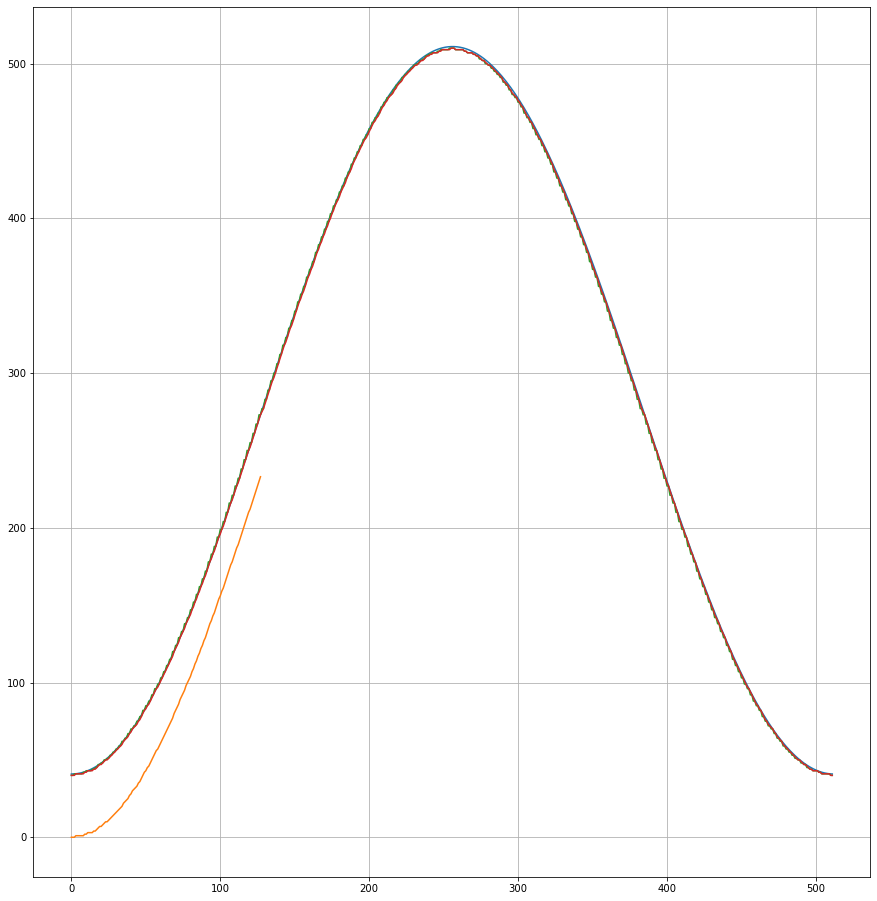

In [165]:
bitprecision = 8 + 1
FFT_size = 512

import math
window = get_window("hamm", FFT_size, fftbins=True)
plt.figure(figsize=(15,16))
curve = window * (2**bitprecision - 1)
# print(curve)
plt.plot(curve)
plt.grid(True)

mywin_full = list(map(lambda x: int(x*(2**bitprecision - 1)), window))
# print(curve.astype(int))
# print(mywin)
# for i in range(len(mywin)//2+1):
#     print(i, mywin[i], mywin[-i-1])

print("after:", mywin_full[FFT_size//4])

mywin = mywin_full[0:FFT_size//4]
#print("total size", len(mywin) * bitprecision)
# [2*mywin[-1] - v for v in reversed(mywin)] + \
# [2*mywin[-1] - v for v in reversed(mywin)] + \
offset_a = 0.54 - 0.46 * np.cos (2 * np.pi * (FFT_size//4) / (FFT_size-1))
offset_b = 0.54 - 0.46 * np.cos (2 * np.pi * (FFT_size//4 + 1) / (FFT_size-1))
print("a, b", int(offset_a * (2**bitprecision - 1)), int(offset_b * (2**bitprecision - 1)))
offset = int((offset_b - offset_a) * (2**bitprecision - 1))
print("raw offset", offset)
mywin_rebuild = mywin + \
        [2*offset+2*mywin[-1] -v for v in reversed(mywin)] + \
        [2*offset+2*mywin[-1] -v for v in mywin] + \
        list(reversed(mywin))
# plt.plot(mywin_rebuild)

small = [mywin[2*i+1] for i in range(len(mywin)//2)]
offsetfirst = small[0]
small = [a -offsetfirst for a in small]
print("1/2", mywin[::2])
small2 = []
previ = small[0]
for i in small:
    small2.append((i + previ) // 2)
    previ = i
    small2.append(i)
plt.plot(small2)
print(len(small) * bitprecision)
print("small", small)
print("small0", small[0])
print([small[i] - small[0] for i in range(len(small))])
print("len small", len(small))

mask_msb = 1 << (int(np.log2(FFT_size)) - 1)
mask_sens = 1 << (int(np.log2(FFT_size)) - 2)
mask_addr = 2 ** (int(np.log2(FFT_size)) - 3) - 1
mask_lsb = 1
print(hex(mask_addr))

offsetlast = 2*offset + 2 * small[-1]
print("offsetlast", offsetlast)
prev = offsetfirst
mycurve = np.zeros(FFT_size, dtype="int")
mysmooth = np.zeros(FFT_size, dtype="int")
for i in range(FFT_size):
    addr = (i >> 1) & mask_addr
        
    if (i & mask_sens):
        addr = ~addr
    #if addr < 0:
    #    print(i, mask_addr + 1 + addr)
    #else:
    #    print(i, addr)
    
    if (((i & mask_msb) >> 1) ^ (i & mask_sens)):
        # print(i, "xor")
        mycurve[i] = offsetlast - small[addr]
    else:
        mycurve[i] = small[addr]
        
    mycurve[i] += offsetfirst
        
    # average point
    mysmooth[i] = mycurve[i]
    if not (i & mask_lsb):
        mysmooth[i] = (mycurve[i] + prev) >> 1
    else:
        prev = mysmooth[i]

plt.plot(mycurve)
plt.plot(mysmooth)
print(mysmooth)
        
# list(map(lambda x: "0x{:02x}".format(x), mywin))

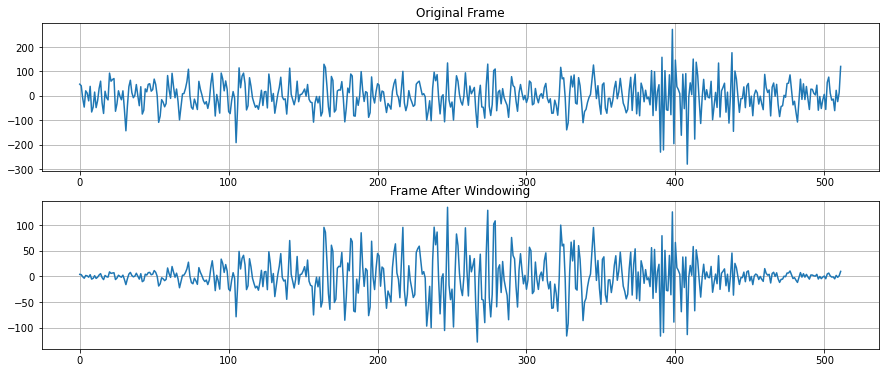

In [166]:
audio_win = audio_framed * window
# audio_win = audio_framed

plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[findex])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[findex])
plt.title('Frame After Windowing')
plt.grid(True)

# print(audio_win[findex])

In the plot above you can see the that both ends of the frame end on different places on the y axis. You can see that the window brought the edges of each frame closer to zero.

Now lets perform the FFT. After we do the FFT we only take the the positive part of the spectrum (first half +1).

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWa

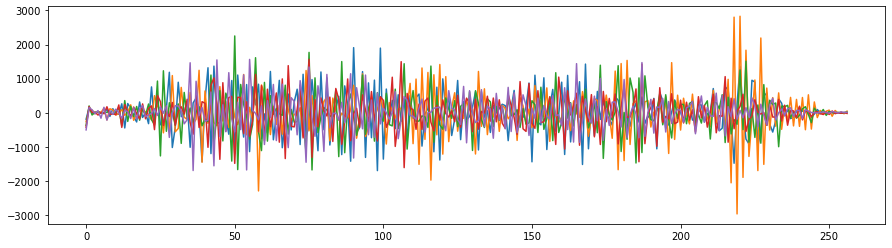

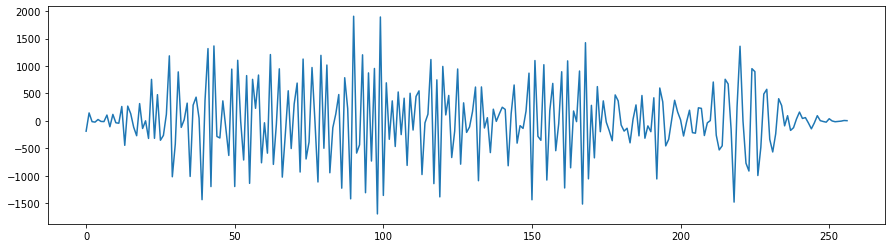

In [167]:
# audio_winT = np.transpose(audio_win)
#print(audio_win.shape)
#print(audio_winT.shape)
# audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
#print(audio_fft.shape)
#print(len(audio_winT[:, 0]))
#print(audio_winT[:, 0].shape)
#print(audio_win[0].shape)
# print(audio_winT[:, 0] == audio_win[0]) # true

#for n in range(audio_fft.shape[1]):
#    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
#audio_fft = np.transpose(audio_fft)
#plt.figure(figsize=(15,4))
#plt.plot(audio_fft[findex])

# simplify
audio_fft = []
size = int(1 + FFT_size // 2)
for i, frame in enumerate(audio_win):
    audio_fft.append(fft.fft(frame, axis=0)[0:size])

plt.figure(figsize=(15,4))
for i in range(5):
    plt.plot(audio_fft[i])
    
plt.figure(figsize=(15,4))
plt.plot(audio_fft[findex])

## Calculate signal power

(92, 257)


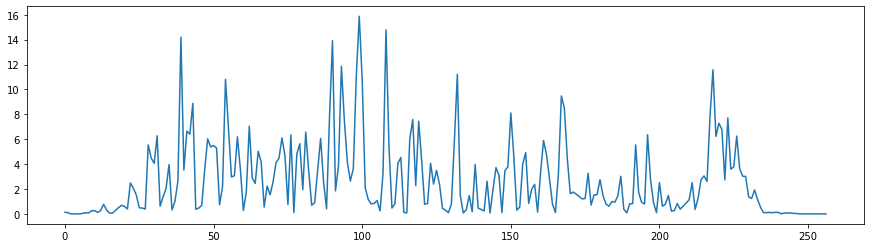

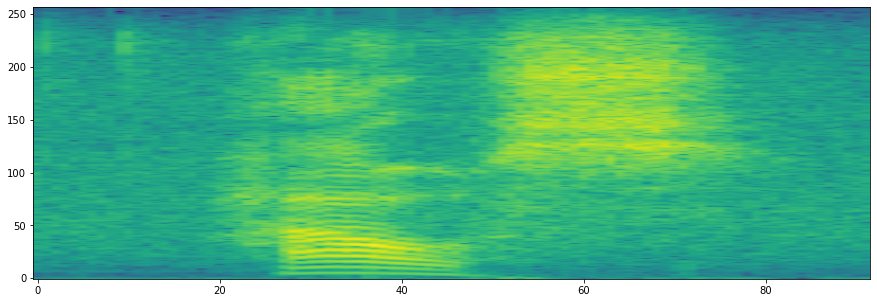

In [168]:
audio_power = np.square(np.abs([a/512 for a in audio_fft]))
print(audio_power.shape)
plt.figure(figsize=(15,4))
# for i in range(10):
    # plt.figure(figsize=(15,4))
    # plt.plot(audio_power[50+i])
plt.plot(audio_power[findex])
# powermax = 4096 # ?
# bwidth = 16
# print(audio_power[12])
# print(list(map(lambda x: "0x{:04x}".format(int(x)), audio_power[60] * (2**bwidth) / powermax)))

# print(audio_power[findex])

plt.figure(figsize=(15,5))
plt.imshow(np.transpose(np.log2(audio_power)), aspect='auto', origin='lower', cmap="viridis");

## MEL-spaced filterbank
Here we compute the MEL-spaced filterbank and then pass the framed audio through them. That will give us information about the power in each frequency band. The filters can be constructed for any frequency band but for our example we will look on the entire sampled band.

What spessial with the MEL-spaced filterbank is the spacing between the filters which grows exponentially with frequency. The filterbank can be made for any frequency band. Here we will compute the filterbank for the entire frequency band.

In [169]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 32

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 8000.0


### Compute filter points
First we construct filter points that determines the start and stop of the filters. To do that we first convert the two filterbank edges to the MEL space. After that we construct a lineary spaced array between the two MEL frequencies. Then we convert the array to the frequency space and finally we normalize the array to the FFT size and choose the associated FFT values.

This process is shown in the picture below:

<a href="https://ibb.co/kCsp4H"><img src="https://preview.ibb.co/hrFnrx/MEL.png" alt="MEL" border="0" /></a>

In [170]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [171]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    print(freqs)
    print(FFT_size)
    print(sample_rate)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [172]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sample_rate)
filter_points

MEL min: 0.0
MEL max: 2840.023046708319
[   0.           55.54845038  115.50494411  180.21928115  250.06901981
  325.46167954  406.83711843  494.67009951  589.47306058  691.7991039
  802.24522314  921.45578634 1050.12629534 1189.00744346 1338.90949524
 1500.70701371 1675.3439628  1863.8392146  2067.29249375 2286.89079345
 2523.91530065 2779.74887082 3055.88409582 3353.93201202 3675.63149949
 4022.85942698 4397.64160205 4802.16459006 5238.78847111 5710.06060929
 6218.73051459 6767.76588417 7360.36991659 8000.        ]
512
16000


array([  0,   1,   3,   5,   8,  10,  13,  15,  18,  22,  25,  29,  33,
        38,  42,  48,  53,  59,  66,  73,  80,  89,  97, 107, 117, 128,
       140, 153, 167, 183, 199, 216, 235, 256])

### Construct the filterbank
After we have the filter points, we construct the filters.

In [173]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    print(filters.shape)
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

(32, 257)
TOTAL 1234 0x4d2
TOTAL 2468 0x9a4
TOTAL 3085 0xc0d
TOTAL 3085 0xc0d
TOTAL 3085 0xc0d
TOTAL 3085 0xc0d
TOTAL 3085 0xc0d
TOTAL 4319 0x10df
TOTAL 4319 0x10df
TOTAL 4319 0x10df
TOTAL 4936 0x1348
TOTAL 5553 0x15b1
TOTAL 5553 0x15b1
TOTAL 6169 0x1819
TOTAL 6787 0x1a83
TOTAL 6786 0x1a82
TOTAL 8021 0x1f55
TOTAL 8638 0x21be
TOTAL 8638 0x21be
TOTAL 9872 0x2690
TOTAL 10489 0x28f9
TOTAL 11106 0x2b62
TOTAL 12340 0x3034
TOTAL 12957 0x329d
TOTAL 14191 0x376f
TOTAL 15425 0x3c41
TOTAL 16659 0x4113
TOTAL 18509 0x484d
TOTAL 19743 0x4d1f
TOTAL 20361 0x4f89
TOTAL 22212 0x56c4
TOTAL 24680 0x6068


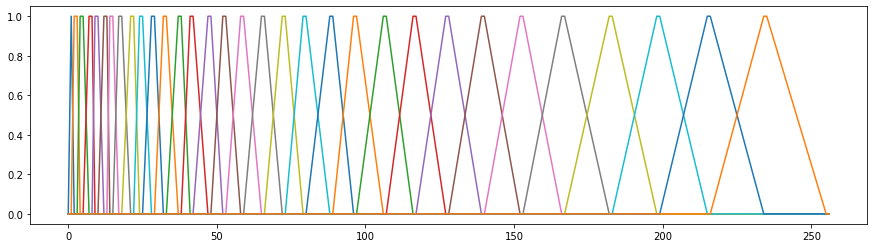

In [174]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

# mult_bitsize = 18

# for f in filters:
#     print("uint32_t")
# filters_int = filters * (2**mult_bitsize)
# filters_int

# print(filters[0])
value = 1234
for f in range(len(filters)):
    mysum = 0
    for i in range(len(filters[f])):
        mysum += filters[f][i] * value
        # print(f, i, mysum)
    print("TOTAL", int(mysum), hex(int(mysum)))

Next we divide the triangular MEL weights by the width of the MEL band (area normalization). If we wont normalize the filters, we will see the noise increase with frequency because of the filter width.

In [175]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
print((mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num]))
# filters *= enorm[:, np.newaxis] # remove norm !

[ 115.50494411  124.67083076  134.5640757   145.24239839  156.76809862
  169.20841997  182.63594215  197.12900439  212.77216256  229.65668244
  247.8810722   267.55165711  288.7831999   311.69957026  336.43446756
  363.13220089  391.94853095  423.05157884  456.6228069   492.85807737
  531.96879517  574.1831412   619.74740367  668.92741496  722.01010256
  779.30516308  841.14686906  907.89601923  979.94204348 1057.70527488
 1141.639402   1232.23411583]


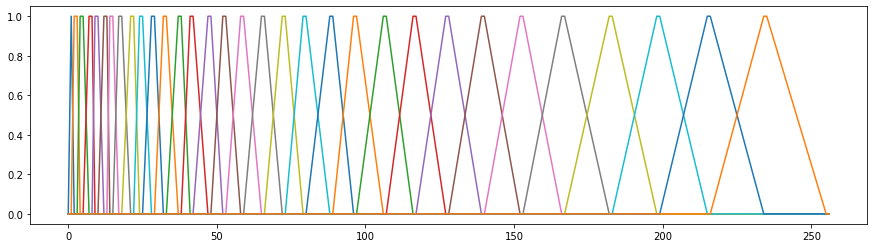

In [176]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

## Filter the signal

[9.23445475e-02 3.62763375e-03 2.53615094e-02 1.98032035e-01
 5.79938952e-01 1.09731623e+00 4.07884984e-01 1.48623698e+00
 4.55247434e+00 3.47615866e+00 1.52495348e+01 1.11269152e+01
 1.70395996e+01 2.77866011e+01 2.04255287e+01 2.55463689e+01
 2.52375273e+01 2.15754758e+01 2.57634254e+01 2.82609383e+01
 4.28653977e+01 5.76803786e+01 3.70417196e+01 3.75426371e+01
 2.73942187e+01 2.37792339e+01 3.87701461e+01 4.74050364e+01
 2.46914035e+01 2.47745477e+01 6.53343926e+01 2.97609176e+01]
max 19.489841150631694


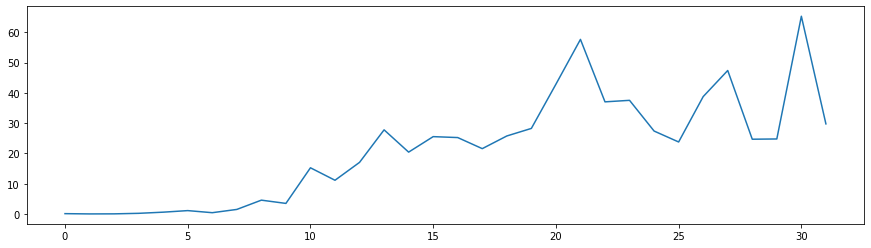

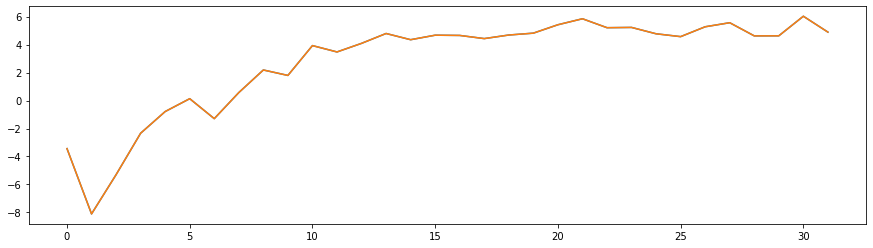

In [177]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
print(np.transpose(audio_filtered)[findex])

plt.figure(figsize=(15,4))
plt.plot(np.transpose(audio_filtered)[findex])

# for res in np.transpose(audio_filtered):
#    print(min(res))
# for res in np.log10(audio_filtered):
#     print(min(res))
# audio_log = 10.0 * np.log10(audio_filtered)
audio_log = np.log2(audio_filtered)
print("max", audio_log.max())

prec = 10
audio_scale = (audio_log * (2**prec)).astype(int) / (2**prec)

plt.figure(figsize=(15,4))
plt.plot(np.transpose(audio_log)[findex])
plt.plot(np.transpose(audio_scale)[findex])

Now we have a matrix represemting the audio power in all 10 filters in different time frames.
## Generate the Cepstral Coefficents
The final step in generating the MFCC is to use the Discrete Cosine Transform (DCT). We will use the DCT-III. This type of DCT will extract high frequency and low frequency changes in the the signal [8] [9].

In [178]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    # print(basis)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

(32, 32)
[ 1.58097359e+01 -1.56504872e+01 -9.56506071e+00 -4.68080265e+00
 -2.23476302e+00 -1.07567792e+00 -2.08621895e-01 -1.26488306e+00
 -9.76688013e-01  1.19507849e-01 -2.21252987e-02  3.20160875e-01
  1.67241904e+00  1.19980574e+00  1.83459259e+00  1.76936855e+00
  1.31483465e+00  1.37338584e+00  5.41822493e-01  1.24456570e+00
 -2.22407132e-01  9.27988634e-01  1.88461583e-01  1.44975538e+00
  1.49277380e+00  1.17899481e+00 -3.45702072e-02 -2.79027433e-04
 -3.17469164e-01  6.65798625e-02  2.39077847e-01  1.41276585e-01]


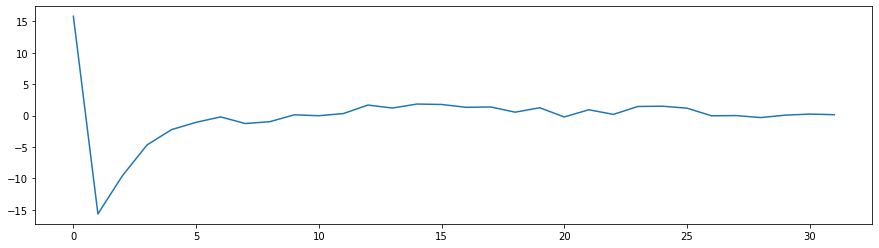

In [179]:
dct_filter_num = mel_filter_num

dct_filters = dct(dct_filter_num, mel_filter_num)
print(dct_filters.shape)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_scale = np.dot(dct_filters, audio_scale)
cepstral_coefficents.shape

print(cepstral_coefficents[:, findex])
plt.figure(figsize=(15,4))
plt.plot(cepstral_coefficents[:, findex])


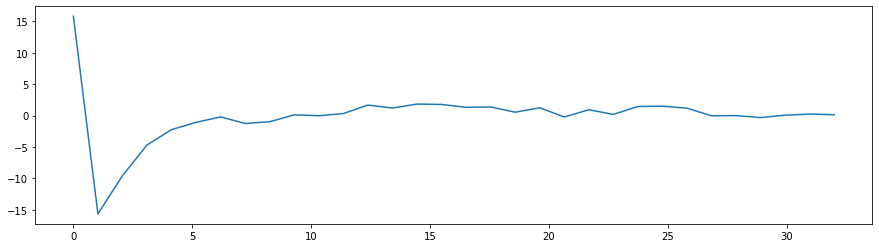

In [180]:
# https://dsp.stackexchange.com/questions/2807/fast-cosine-transform-via-fft
mydata = np.transpose(audio_log)[findex]
#A1 = scipy.fft.dct(mydata, type=2, norm="ortho")
#print("A1", A1)
A2 = scipy.fft.dct(mydata, type=2, norm="ortho", n=dct_filter_num)
# print("A2", A2)
#A3 = scipy.fft.dct(list(mydata) + [0]*(dct_filter_num-mel_filter_num), type=2, norm="ortho")

plt.figure(figsize=(15,4))
#plt.plot(cepstral_coefficents[:, findex])
#plt.plot(A1)
plt.plot(np.linspace(0, mel_filter_num, num=dct_filter_num), A2)
# plt.plot(np.linspace(0, mel_filter_num, num=dct_filter_num), A3)
#A1ext = [a for a in A1] + [-a for a in reversed(A1)]
#A1ext = [a for a in A1ext] + [a for a in reversed(A1ext)]
# plt.plot(A1ext)
# print("A1ext", A1ext)

#mydata4 = [0] * 4 * len(mydata)
#for i in range(len(mydata)):
#    mydata4[2*i+1] = mydata[i]
#    mydata4[4*len(mydata)-(2*i+1)] = mydata[i]
#print(mydata)
# print(mydata4)
#B = scipy.fft.fft(mydata4) # [:len(mydata)]
#print("B", B[:len(mydata)])
#plt.figure(figsize=(15,4))
# plt.plot(B)
#C = scipy.fft.ifft(B)
# print("C", C)
#D = scipy.fft.idct(A)
# print("D", D)

In [181]:
# [a, b, c, d] becomes
# [0, a, 0, b, 0,  c,  0,  d,  0,  d,  0,  c, 0, b, 0, a].
# [A, B, C, D, 0, -D, -C, -B, -A, -B, -C, -D, 0, D, C, B]

data = ["a", "b", "c", "d"]
dataz = data + ["0"]
dout = [0] * 4*len(data)
sign = 1
dirt = 1
j = 0
for i in range(len(dout)):
    print(j, sign)
    dout[i] = str(sign) + dataz[j]
    if (dirt == 1):
        if (j < len(dataz)-1):
            j += 1
        else:
            j -= 1
            sign *= -1
            dirt *= -1
    else:
        if (j > 0):
            j -= 1
        else:
            j += 1
            dirt *= -1
print(dout)

0 1
1 1
2 1
3 1
4 1
3 -1
2 -1
1 -1
0 -1
1 -1
2 -1
3 -1
4 -1
3 1
2 1
1 1
['1a', '1b', '1c', '1d', '10', '-1d', '-1c', '-1b', '-1a', '-1b', '-1c', '-1d', '-10', '1d', '1c', '1b']


## Reviewing Cepstral coefficents

In [182]:
def lifter(cepstra, L=22):
    """Apply a cepstral lifter the the matrix of cepstra. This has the effect of increasing the
    magnitude of the high frequency DCT coeffs.
    :param cepstra: the matrix of mel-cepstra, will be numframes * numcep in size.
    :param L: the liftering coefficient to use. Default is 22. L <= 0 disables lifter.
    """
    if L > 0:
        nframes,ncoeff = np.shape(cepstra)
        print("nframes", nframes, "ncoeff", ncoeff)
        n = np.arange(ncoeff)
        lift = 1 + (L/2.)*np.sin(np.pi*n/L)
        return lift*cepstra
    else:
        # values of L <= 0, do nothing
        return cepstra

In [183]:
print(cepstral_coefficents[:, 0])

ceplifter = 22
cepstra = np.transpose(cepstral_coefficents)
features = lifter(cepstra, ceplifter)
features = np.transpose(features)

cepstra = np.transpose(cepstral_scale)
features_scale = lifter(cepstra, ceplifter)
features_scale = np.transpose(features_scale)

print(features[:, 0])

[ 1.58097359e+01 -1.56504872e+01 -9.56506071e+00 -4.68080265e+00
 -2.23476302e+00 -1.07567792e+00 -2.08621895e-01 -1.26488306e+00
 -9.76688013e-01  1.19507849e-01 -2.21252987e-02  3.20160875e-01
  1.67241904e+00  1.19980574e+00  1.83459259e+00  1.76936855e+00
  1.31483465e+00  1.37338584e+00  5.41822493e-01  1.24456570e+00
 -2.22407132e-01  9.27988634e-01  1.88461583e-01  1.44975538e+00
  1.49277380e+00  1.17899481e+00 -3.45702072e-02 -2.79027433e-04
 -3.17469164e-01  6.65798625e-02  2.39077847e-01  1.41276585e-01]
nframes 92 ncoeff 32
nframes 92 ncoeff 32
[ 1.58097359e+01 -4.01507493e+01 -3.92077398e+01 -2.60700353e+01
 -1.55250082e+01 -8.82428949e+00 -1.94294688e+00 -1.29698439e+01
 -1.07493813e+01  1.38084420e+00 -2.63026344e-01  3.84193050e+00
  1.98817775e+01  1.38630627e+01  2.01914379e+01  1.81427315e+01
  1.22453777e+01  1.12665269e+01  3.76406740e+00  6.93168973e+00
 -9.11659763e-01  2.38072071e+00  1.88461583e-01 -8.19783347e-01
 -3.13341896e+00 -4.20849877e+00  1.71020509e-0

mean [-1.05272737e-01 -4.52064308e-01 -2.20569300e-01 -2.69882679e-01
 -2.64659667e-01  3.15605536e-02  2.69337999e-02  7.06498565e-02
 -2.27740578e-01 -1.24566721e-01 -1.20608956e-01 -2.72300791e-01
 -2.41960532e-01 -2.71791136e-01 -1.46264157e-01  7.81184544e-04
 -6.74684238e-01 -2.62602586e-01 -4.42295266e-01  2.30198350e-01
  1.16569478e-01  7.16782842e-02 -1.69759031e-01 -1.20135218e-01
 -1.27631019e-01  2.72689107e-01 -9.25741569e-03 -2.18701729e-01
 -2.67524817e-01  8.37871978e-01  8.30288252e-01  5.37366208e-01
  4.70281789e-01  6.50014689e-01  7.91656823e-01  5.64880522e-01
  1.21267309e+00  1.22559996e+00  9.41837109e-01  8.01141608e-01
  5.79428181e-01  9.04550459e-01 -1.96546214e-01 -1.94499294e-01
 -3.06693124e-01 -5.25524290e-01 -5.07182839e-01  7.35038657e-02
  5.28876111e-01  2.64011830e-01  4.74368989e-01  1.15847957e+00
  1.29044590e+00  1.16838177e+00  1.21743471e+00  1.12587050e+00
  4.96919562e-01  3.05039721e-01  4.21625877e-01  3.18625504e-01
 -3.73803418e-01  2.

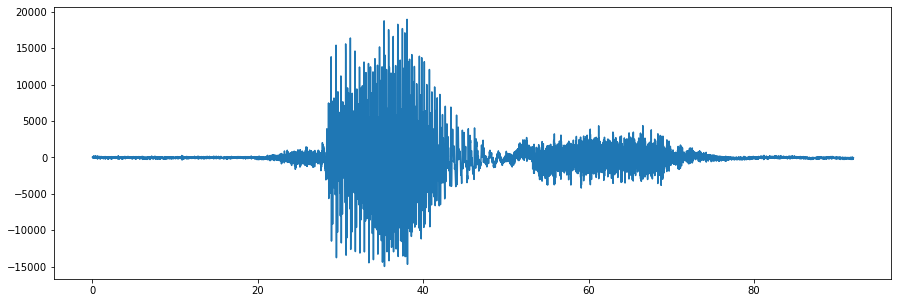

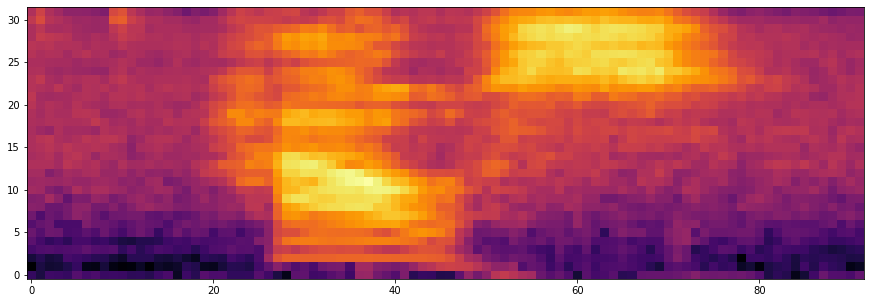

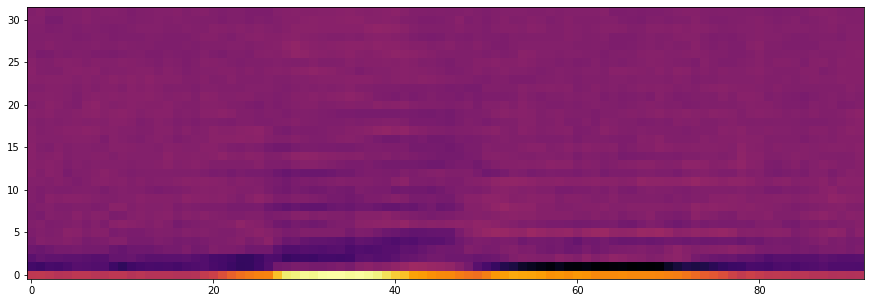

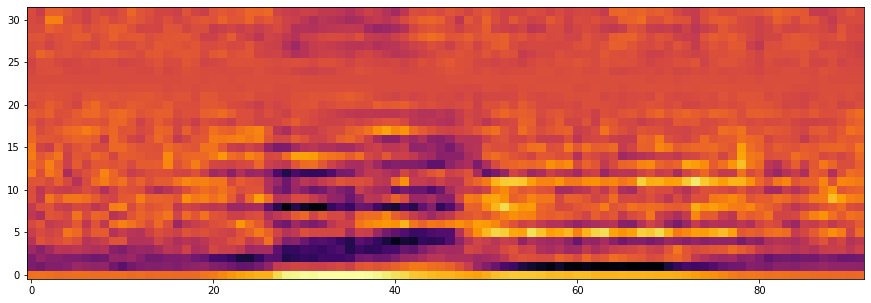

<Figure size 1080x360 with 0 Axes>

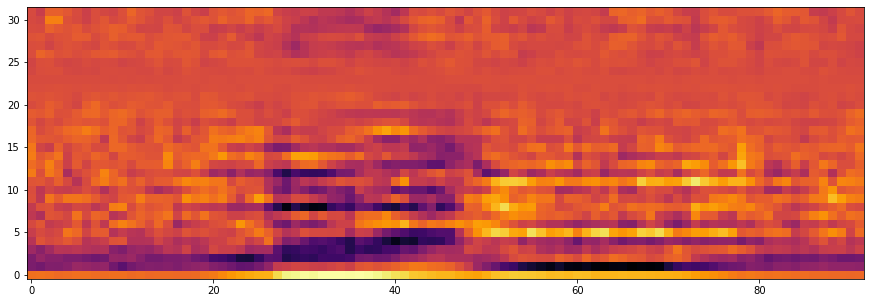

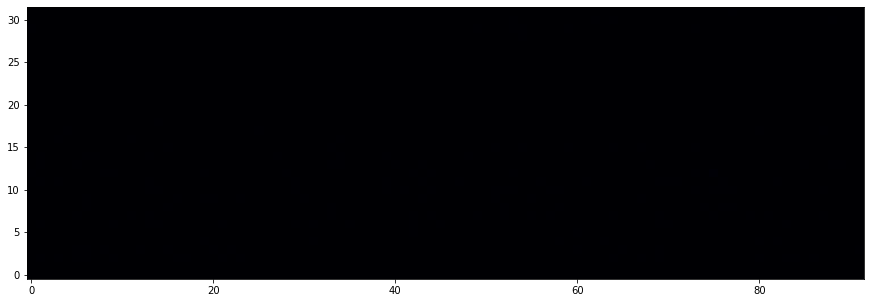

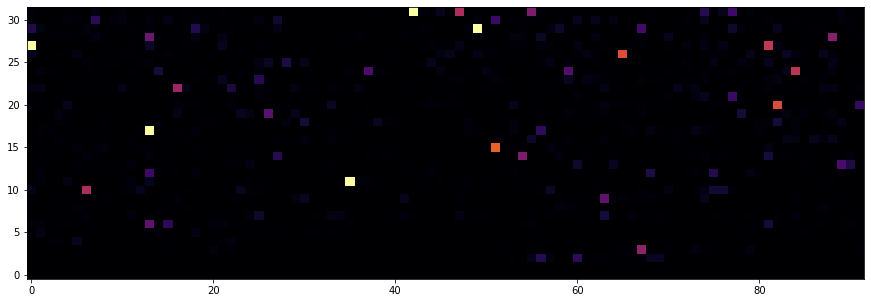

In [184]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, cepstral_coefficents.shape[1], num=len(audio)), audio)

plt.figure(figsize=(15,5))
plt.imshow(audio_log, aspect='auto', origin='lower', cmap="inferno");

plt.figure(figsize=(15,5))
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower', cmap="inferno");

print("mean", np.mean(cepstral_coefficents, axis=0))

plt.figure(figsize=(15,5))
plt.imshow(features, aspect='auto', origin='lower', cmap="inferno");
print(abs(features).max())

plt.figure(figsize=(15,5))
#plt.imshow(cepstral_scale, aspect='auto', origin='lower', cmap="inferno");

plt.figure(figsize=(15,5))
plt.imshow(features_scale, aspect='auto', origin='lower', cmap="inferno");

plt.figure(figsize=(15,5))
diff = abs(features_scale - features)
print(diff)
print("diff max:", diff.max())
plt.imshow(diff, aspect='auto', origin='lower', cmap="inferno", vmin=0, vmax=1.5);

plt.figure(figsize=(15,5))
error = abs(diff / features) * 100.0
print(error)
print("error:", error.max())
plt.imshow(error, aspect='auto', origin='lower', cmap="inferno", vmin=0, vmax=10);

# Conclution
The MFCC is a good algorithm to extract high frequency and low frequency information. There are many parts that can be changed depending on the application. One thing that we might want to check is how the power is scattered across frequency band and choosing the filter amount based on that.

# Bibliography
[1] https://en.wikipedia.org/wiki/Voice_frequency

[2] https://en.wikipedia.org/wiki/Hearing_range

[3] https://www.sfu.ca/sonic-studio/handbook/Mel.html

[4] https://en.wikipedia.org/wiki/Mel_scale

[5] http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

[6] https://librosa.github.io/librosa/

[7] https://en.wikipedia.org/wiki/Window_function#Hamming_window

[8] https://www.youtube.com/watch?v=Q2aEzeMDHMA

[9] https://en.wikipedia.org/wiki/Discrete_cosine_transform